## 필요한 패키지 import 하기
- cv2: [OpenCV](https://opencv.org/) → 오픈 소스 컴퓨터 비전 라이브러리
- dlib: 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

In [ ]:
os.getcwd()

## 스티커 적용할 이미지 불러오기
`cv2.imread()`: 파일 경로로부터 이미지 불러오기
`cv2.cvtColor(image, cv2.COLOR_BGR2RGB)`: OpenCV는 BGR을 쓰고, Matplotlib과 같은 라이브러리는 보통 RGB를 쓰기 때문에 그대로 출력하면 빨간색이 파란색으로, 파란색이 빨간색으로 나옴.


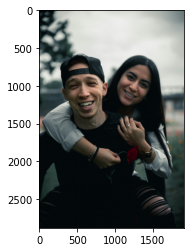

In [2]:
img_name = 'selfie2'
my_image_path = '/aiffel/aiffel/project/camera_sticker/images/'+ img_name + '.png'
img_bgr = cv2.imread(my_image_path)
# 출력용 이미지 복사해두기
img_show = img_bgr.copy()      
# 이미지 출력
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출(face detection)
기본 detector: `dlib`의 face detector 활용  
-> 찾은 얼굴 영역의 박스 리스트 생성

In [3]:
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

> 모델 선정 이유: `dlib`의 `get_frontal_face_detector`는 hog와 svm을 사용하여 사람의 얼굴을 인식하기 때문에 이번 프로젝트의 목적에 잘 부합한다. 다만 이름에서도 알 수 있다시피 정면 얼굴에만 특화되어 있다는 단점이 있다. 
또한, 딥러닝 모델이 아니어서 metric과 loss는 사용하지 않았다
동일한 이유로 데이터 분할이나 하이퍼 파라미터 튜닝 등의 딥러닝 학습 기법은 사용하지 않았다

rectangles[[(1016, 811) (1478, 1273)], [(348, 862) (810, 1324)], [(151, 450) (259, 558)]]


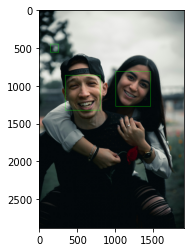

In [4]:
# bounding box 그려보기
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 랜드마크(face landmark)
- top-down 방식을 사용하기 때문에 bounding box 내부의 keypoint를 예측  
- `shape_predictor`: landmark 모델. RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환  
    - `dlib.rectangle`: 내부를 예측하는 박스  
    - `dlib.full_object_detection`: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄. 개별 위치는 `parts()`로 접근할 수 있음

In [7]:
# landmark 모델을 저장할 파일 경로
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
# 랜드마크의 위치를 저장할 list 생성    
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)

print(len(list_landmarks), len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list
    
num_faces = len(list_landmarks)    # 얼굴 개수 저장

3 68


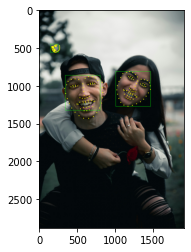

In [9]:
# 랜드마크를 원본 이미지 위에 표시
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 6, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # 크기가 큰 이미지는 원 크기도 키워야 함

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 필요한 부위의 좌표 저장
고양이 수염 모양의 스티커이므로 코를 가리키는 랜드마크의 위치 저장

In [10]:
# 각 얼굴에 맞는 코끝, 영역 크기를 저장할 딕셔너리 생성
positions = {"x":[],"y":[],"w":[], "h":[]};

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 콧대 아랫부분의 index: 30
    x = landmark[30][0] # 이미지에서 코의 x값
    y = landmark[30][1] # 이미지에서 코의 y값
    w = h = dlib_rect.width() # 얼굴 영역 가로 크기의 픽셀 수 = 세로 픽셀 수
    # 위치 저장
    positions['x'].append(x)
    positions['y'].append(y)
    positions['w'].append(w)
    positions['h'].append(h)

    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(1254, 1046)
(x,y) : (1254,1046)
(w,h) : (463,463)
(598, 1129)
(x,y) : (598,1129)
(w,h) : (463,463)
(193, 512)
(x,y) : (193,512)
(w,h) : (109,109)


## 스티커 이미지 불러오기
각 얼굴 크기에 맞춰 사이즈 조정하기

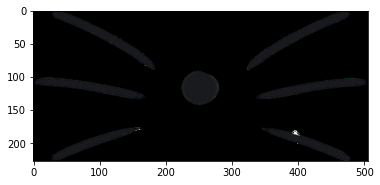

(231, 463, 3)
(231, 463, 3)
(54, 109, 3)


In [11]:
# 얼굴이 여러 개일 수 있으므로 다양한 크기의 스티커를 저장하기 위해 리스트 생성
img_stickers=[]

sticker_path = '/aiffel/aiffel/project/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
plt.show()

for i in range(num_faces):
    # 스티커 이미지의 가로, 세로 크기 각각 w,h/2로 조정
    img_stickers.append(cv2.resize(img_sticker, (positions['w'][i],positions['h'][i]//2)))
    # 크기 조정된 이미지 확인
    print (img_stickers[i].shape)

## 원본 이미지에 스티커 붙이기

### 스티커를 붙일 범위 설정

In [12]:
# 왼쪽 위를 기준으로 스티커가 붙기 때문에 왼쪽 위 좌표가 계산되어야 함
positions['refined_x'] = []
positions['refined_y'] = []

for i in range(num_faces):
    positions['refined_x'].append(positions['x'][i] - positions['w'][i] // 2)
    positions['refined_y'].append(positions['y'][i] - positions['h'][i]//4)
    print ('(x,y) : ', positions['refined_x'][i], ', ',positions['refined_y'][i])


(x,y) :  1023 ,  931
(x,y) :  367 ,  1014
(x,y) :  139 ,  485


In [13]:
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 음수값 만큼 적용할 스티커 이미지를 자른다.
for i in range(num_faces):
    if positions['refined_x'][i] < 0: 
        img_stickers[i] = img_stickers[i][:, -positions['refined_x'][i]:]
        positions['refined_x'][i] = 0
    if positions['refined_y'][i] < 0:
        img_stickers[i] = img_stickers[i][-positions['refined_y'][i]:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
        positions['refined_y'][i] = 0
    print(img_stickers[i].shape)

(231, 463, 3)
(231, 463, 3)
(54, 109, 3)


### 얼굴 각도에 맞추어 스티커 회전시키기

<function matplotlib.pyplot.show(close=None, block=None)>

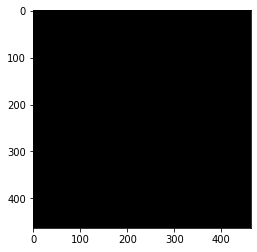

In [21]:
import math

cnt = 0
for landmark in list_landmarks: # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    # 얼굴 각도 구하기 - 관자놀이 부분의 위치 차이로 확인
    left = landmark[0] # 왼쪽 눈 옆(관자놀이) index: 0
    right = landmark[16] # 오른쪽 눈 옆(관자놀이) index: 16
    x_delta = right[0] - left[0]
    y_delta = right[1] - left[1]
    angle = -math.degrees(math.atan2(y_delta, x_delta))
    # 스티커 이미지 회전
    m = cv2.getRotationMatrix2D(tuple(landmark[0]),angle,1)    # 중심을 기준으로
    img_stickers[cnt] = cv2.warpAffine(img_stickers[cnt], m, (positions['w'][cnt], positions['h'][cnt]))

plt.imshow(img_stickers[0])
plt.show

### 스티커 적용하기

In [ ]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 원본 이미지에서 sticker_area에 해당하는 만큼 스티커 삽입
# 스티커 이미지에서 투명한 부분(0)은 원본 이미지로, 아닌 부분은 스티커 이미지로 대체
for i in range(num_faces):
    sticker_y = positions['refined_y'][i]
    sticker_x = positions['refined_x'][i]
    sticker_area = img_show[sticker_y:sticker_y+img_stickers[i].shape[0],
                            sticker_x:sticker_x+img_stickers[i].shape[1]]
    print(sticker_area.shape)
    img_show[sticker_y:sticker_y+img_stickers[i].shape[0], 
             sticker_x:sticker_x+img_stickers[i].shape[1]] = \
    np.where(img_stickers[i]==0,sticker_area,img_stickers[i]).astype(np.uint8)


In [ ]:
# 스티커 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
for i in range(num_faces):
    sticker_y = positions['refined_y'][i]
    sticker_x = positions['refined_x'][i]
    # img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
    sticker_area = img_bgr[sticker_y:sticker_y+img_stickers[i].shape[0],
                            sticker_x:sticker_x+img_stickers[i].shape[1]]
    print(sticker_area.shape)
    img_bgr[sticker_y:sticker_y+img_stickers[i].shape[0], 
             sticker_x:sticker_x+img_stickers[i].shape[1]] = \
    np.where(img_stickers[i]==0,sticker_area,img_stickers[i]).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

## 스티커 붙인 이미지 저장

In [ ]:
result = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
save_path = '/aiffel/aiffel/project/camera_sticker/results/'+ img_name + '_with_sticker.png'
plt.imsave(save_path, result)